In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import numpy as np

from cassL import camb_interface as ci
from cassL import user_interface as ui
from cassL import utils

import camb
from camb import model, initialpower

import copy as cp

In [2]:
import importlib.util
import sys

spec = importlib.util.spec_from_file_location(
    "andreap", "../emulator/andreap.py")
andreap = importlib.util.module_from_spec(spec)
sys.modules["andreap"] = andreap
spec.loader.exec_module(andreap)

In [3]:
# Axe the 0.01 value since Ariel has not tested that one in the shared results
powernu3 = ci.load_benchmark(
    "../../benchmarks/power_nu3/Aletheia_powernu3_zorig_nu",
    ["0.0006", "0.0021", "0.0064", "0.0100"] 
)

In [4]:
spectra = ci.boltzmann_battery(ci.OMNUH2_FLOATS, skips_omega=[],
                               skips_model=[8], k_points=1000,
                               skips_snapshot=[])

In [5]:
np.save("Lukas_spectra.npy", spectra)

spectra = np.load("Lukas_spectra.npy", allow_pickle=True).item()

In [6]:
Andrea_swarm = []
Ariel_swarm = []
k_axes = []

omnuh2_index = 0
for key in spectra:
    omnuh2 = key
    print(key)
 
    for modeli in range(len(spectra[key])):
        #print("model", modeli)
        if modeli == 8:
            continue
            
        model = ci.cosm.iloc[modeli]
        model = ci.specify_neutrino_mass(model, omnuh2, 1)
        
        z_array = ci.parse_redshifts(modeli)
        
        for snapi in range(len(spectra[key][modeli])):
            #print("snap", snapi)
            z = z_array[snapi]
            
            Lukas_spec = spectra[key][modeli][snapi]
            Ariel_spec = powernu3[ci.OMNUH2_STRS[omnuh2_index]][modeli][snapi]

            andrea_interpolator = andreap.cassL_to_andrea_cosmology(
                model, hybrid=False)
            
            if omnuh2_index == 0: # add the massless-neutrino case to our errors just once
                samples = np.zeros((2, 2, 1000))
                samples[0][0] = Ariel_spec["k"]
                samples[0][1] = Ariel_spec["P_no"]
                samples[1][0] = Lukas_spec["k"]
                samples[1][1] = Lukas_spec["P_no"]
                base_k, interpd_P = utils.homogenize_k_axes(samples)
            
                andrea_no_Pk = andrea_interpolator['mzero'].P(z, base_k)
                Andrea_errors = (andrea_no_Pk - interpd_P[1]) / andrea_no_Pk
                Andrea_swarm.append(Andrea_errors)
                Ariel_errors = (interpd_P[0] - interpd_P[1]) / interpd_P[0]
                Ariel_swarm.append(Ariel_errors)
                k_axes.append(base_k)
            
            samples = np.zeros((2, 2, 1000))
            samples[0][0] = Ariel_spec["k"]
            samples[0][1] = Ariel_spec["P_nu"]
            samples[1][0] = Lukas_spec["k"]
            samples[1][1] = Lukas_spec["P_nu"]
            base_k, interpd_P = utils.homogenize_k_axes(samples)
            
            andrea_Pk = andrea_interpolator['mnu'].P(z, base_k)
            Andrea_errors = (andrea_Pk - interpd_P[1]) / andrea_Pk
            Andrea_swarm.append(Andrea_errors)
            Ariel_errors = (interpd_P[0] - interpd_P[1]) / interpd_P[0]
            Ariel_swarm.append(Ariel_errors)
            k_axes.append(base_k)
            
    omnuh2_index += 1

0.0006356
0.002148659574468
0.006356
0.01


In [7]:
np.save("Andrea_swarm.npy", Andrea_swarm)
#np.save("Ariel_swarm.npy", Ariel_swarm)

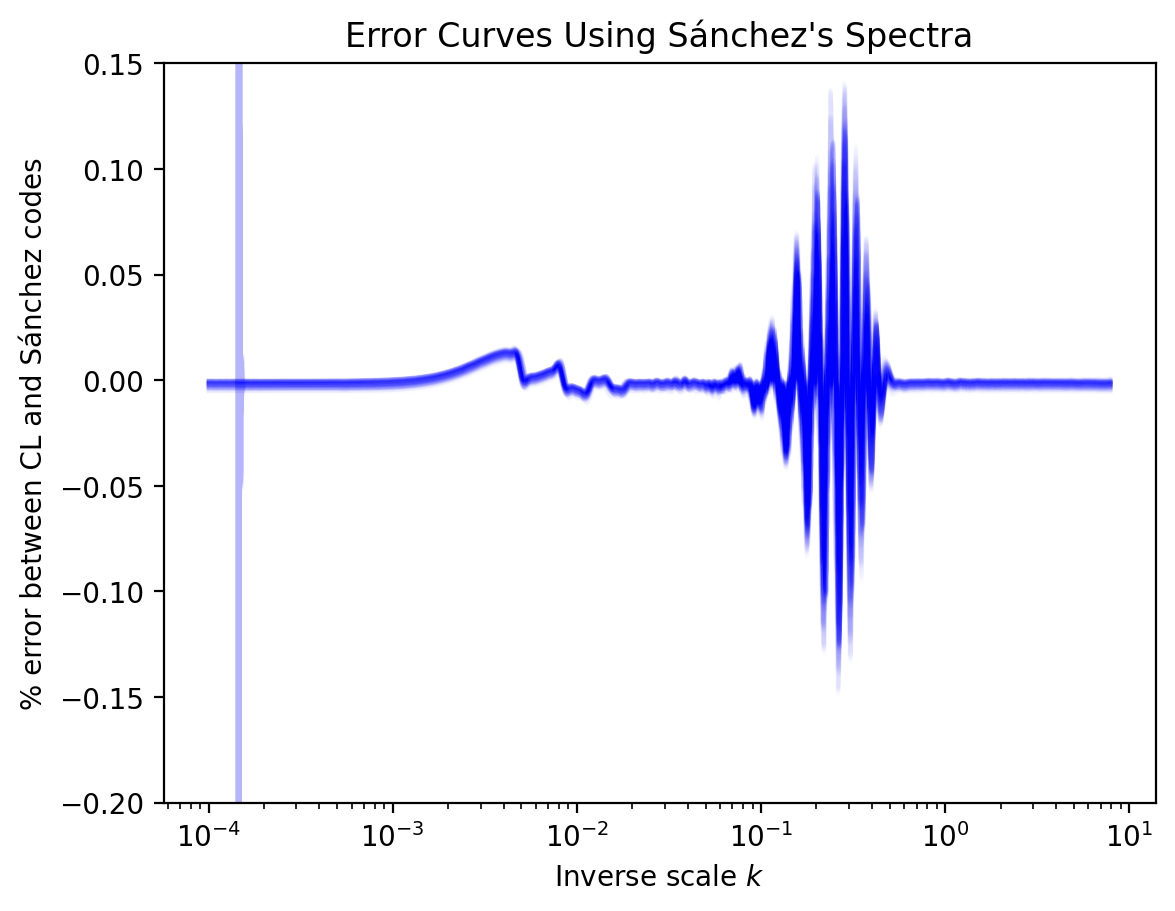

In [8]:
Ariel_swarm = np.load("Ariel_swarm.npy")

for i in range(len(Ariel_swarm)):
    plt.plot(k_axes[i], 100 * Ariel_swarm[i], color="blue", alpha=0.01)

plt.xscale('log')
plt.ylim((-0.2, 0.15))
plt.ylabel("% error between CL and Sánchez codes")
plt.xlabel("Inverse scale $k$")
plt.title("Error Curves Using Sánchez's Spectra")
plt.savefig("../plots/camb_interface/accuracy/Ariel.png")

Text(0.5, 1.0, "Error Curves Using Pezzotta's Spectra")

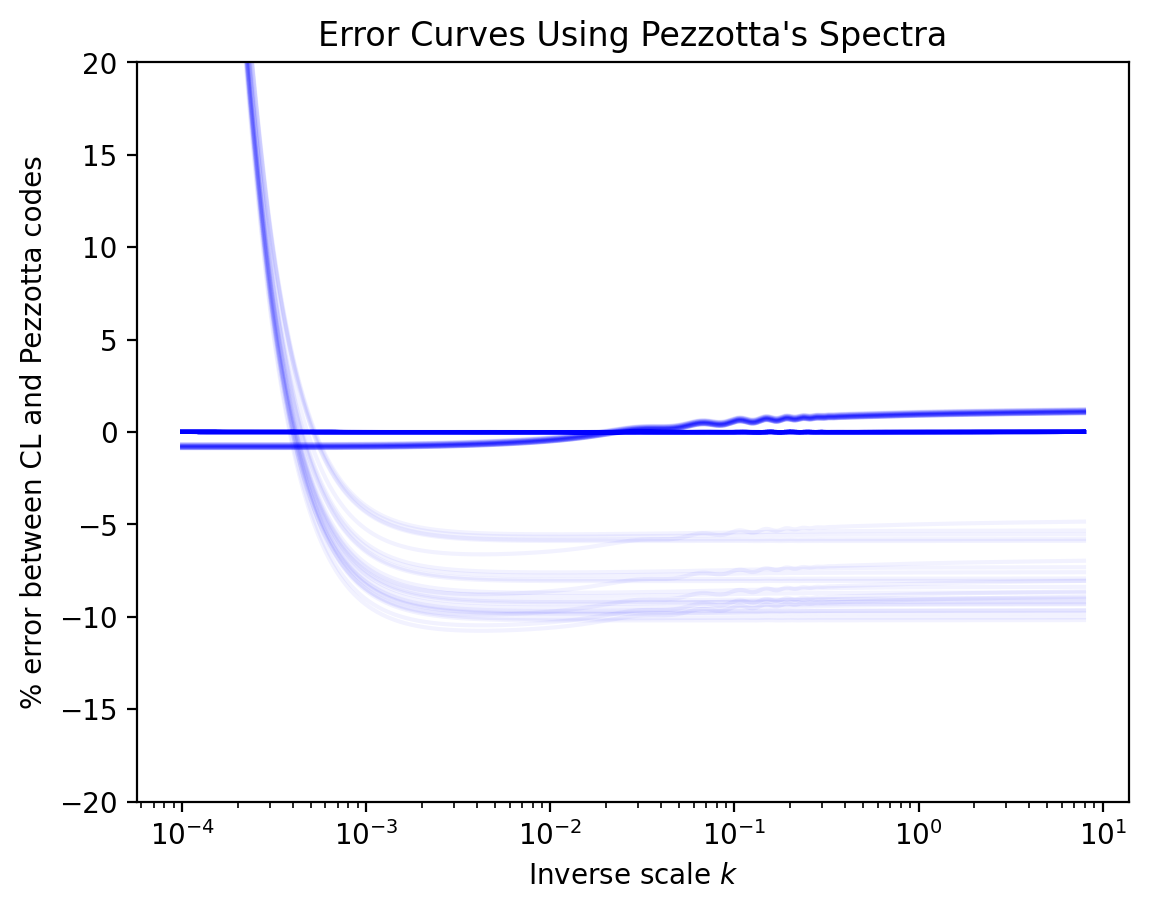

In [12]:
for i in range(int(len(Andrea_swarm))):
    plt.plot(k_axes[i], 100 * Andrea_swarm[i], color="blue", alpha=0.05)

plt.xscale('log')
plt.ylabel("% error between CL and Pezzotta codes")
plt.ylim((-20, 20))
plt.xlabel("Inverse scale $k$")
plt.title("Error Curves Using Pezzotta's Spectra")

Text(0.5, 1.0, "Error Curves Using Pezzotta's Spectra")

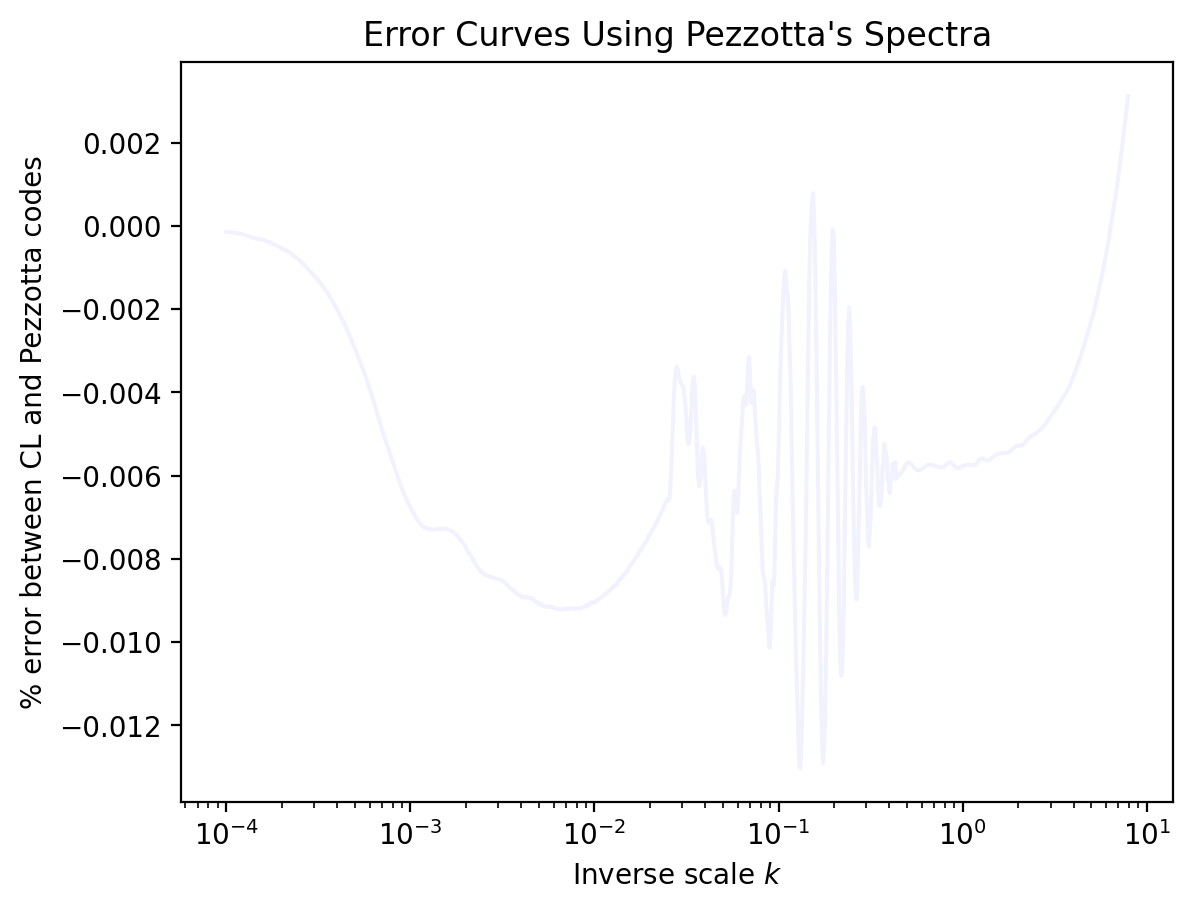

In [16]:
i = 3
plt.plot(k_axes[i], 100 * Andrea_swarm[i], color="blue", alpha=0.05)

plt.xscale('log')
plt.ylabel("% error between CL and Pezzotta codes")
#plt.ylim((-20, 20))
plt.xlabel("Inverse scale $k$")
plt.title("Error Curves Using Pezzotta's Spectra")